In [9]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import seaborn
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report


In [10]:
# src_path: input the path of the folder, where the whole data is stored
# label_path: dataframe which includes label data

src_path="C:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/TrainingsDatensatz"
label_path = os.path.join(src_path, "40_Spulen_MultiLabel_v1.csv")
saveModel_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Modelle/InceptionV3_MultiLabel_v3.hdf5"
#save_logs_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Logs/MultiOuput_Inception_4Outputs_v1_logs"

# path_Data: input the path of the folder, where the whole data is stored
#path_Data="/content/drive/My Drive/MA/CNN_V1/CNN_V1_1_Binary/"


In [11]:
import wandb
wandb.init(project="InceptionV3_multilabel")

In [12]:
import tensorflow_addons as tfa

# Using pretrained ResNet50 in the head of the Networks
pre_trained_model = InceptionV3(input_shape=(299, 299, 3),
                                include_top=False,
                                weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer("mixed10")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation="relu")(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add 4 final sigmoid layer for classification

Wickelfehler = layers.Dense(4, activation='sigmoid', name="Wickelfehler")(x)

model = Model(pre_trained_model.input, Wickelfehler)
model.compile(optimizer=RMSprop(lr=0.001, decay=1e-6),
              loss="binary_crossentropy",
              metrics=tfa.metrics.F1Score(num_classes=4, threshold=0.5))

model.summary()

last layer output shape:  (None, 8, 8, 2048)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
__________________________________________

max_pooling2d_6 (MaxPooling2D)  (None, 17, 17, 288)  0           mixed2[0][0]                     
__________________________________________________________________________________________________
mixed3 (Concatenate)            (None, 17, 17, 768)  0           activation_120[0][0]             
                                                                 activation_123[0][0]             
                                                                 max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 17, 17, 128)  98304       mixed3[0][0]                     
__________________________________________________________________________________________________
batch_normalization_128 (BatchN (None, 17, 17, 128)  384         conv2d_128[0][0]                 
__________________________________________________________________________________________________
activation

                                                                 activation_147[0][0]             
                                                                 activation_152[0][0]             
                                                                 activation_153[0][0]             
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_158 (BatchN (None, 17, 17, 192)  576         conv2d_158[0][0]                 
__________________________________________________________________________________________________
activation_158 (Activation)     (None, 17, 17, 192)  0           batch_normalization_158[0][0]    
__________________________________________________________________________________________________
conv2d_159

__________________________________________________________________________________________________
conv2d_182 (Conv2D)             (None, 8, 8, 384)    442368      activation_180[0][0]             
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 8, 8, 384)    442368      activation_184[0][0]             
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 8, 8, 384)    442368      activation_184[0][0]             
__________________________________________________________________________________________________
average_pooling2d_17 (AveragePo (None, 8, 8, 2048)   0           mixed9[0][0]                     
__________________________________________________________________________________________________
conv2d_179 (Conv2D)             (None, 8, 8, 320)    655360      mixed9[0][0]                     
__________

In [13]:
df = pd.read_csv(label_path)

###.....................................................

df = df.sample(frac=1, random_state=1233).reset_index(drop=True)

###.....................................................

columns=["0_inOrdnung", "1_Doppelwindung", "2_Luecke","3_Kreuzung"]

datagen = ImageDataGenerator(rescale=1. / 255., validation_split=0.15)
# train_datagen=ImageDataGenerator(rescale=1./255.)
# valid_datagen=ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=src_path,
    x_col="Image",
    y_col=columns,
    subset="training",
    batch_size=64,
    shuffle=True,
    class_mode="raw",
    target_size=(299, 299)
    )

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=src_path,
    x_col="Image",
    y_col=columns,
    subset="validation",
    batch_size=64,
    shuffle=False,
    class_mode="raw",
    target_size=(299, 299)
    )


Found 32336 validated image filenames.
Found 5706 validated image filenames.


In [15]:
# Using EarlyStopping Callbacks 
earlystopping = EarlyStopping(
    patience=5,
    min_delta=0,
    mode='min',
    monitor='val_loss',
    restore_best_weights=True,
    verbose=1)

# Using Tesorboard Callbacks
# tensorboard_callback = TensorBoard(log_dir=save_logs_path)

# Using ReduceLROnPlateau Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                              patience=3, min_lr=0.0001)

# Using Checkpoint Callbacks
checkpoint_filepath = saveModel_path
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=0,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=1,
                              verbose=1,
                              workers=6,
                              max_queue_size=20,
                              use_multiprocessing=False,
                              callbacks=[earlystopping, reduce_lr, checkpoint],
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID)

505/505 [==============================] - ETA: 0s - loss: 0.3123 - f1_score: 0.8181WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001DD88FFCF78> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 

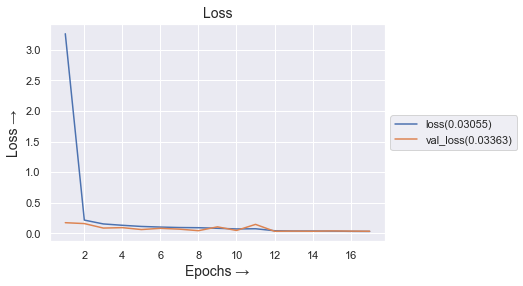

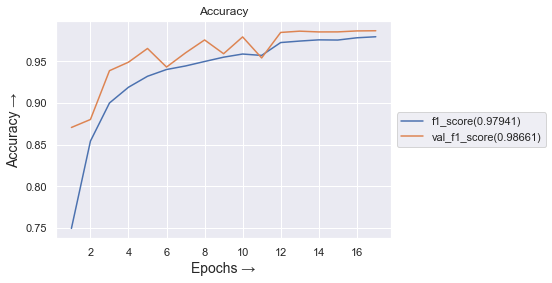

In [83]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'f1_score' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'f1_score' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left")
    plt.title("Loss", fontsize = 14)
    plt.xlabel("Epochs →", fontsize = 14)
    plt.ylabel("Loss →", fontsize = 14)
    plt.savefig("InceptionV3MultiLabelLoss_v2.jpg", dpi = 300, bbox_inches = 'tight')
   
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, np.mean(history.history[l], axis=1),  label= str(l) + '(' + str(format(history.history[l][-1].mean(),'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, np.mean(history.history[l], axis=1),  label= str(l) + '(' + str(format(history.history[l][-1].mean(),'.5f'))+')')

    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left") 
    plt.title('Accuracy')
    plt.xlabel("Epochs →", fontsize = 14)
    plt.ylabel("Accuracy →", fontsize = 14)
    
    plt.savefig("InceptionV3MultiLabelAccurracy_v2.jpg", dpi = 300, bbox_inches = 'tight')
    plt.show()
    
plot_history(history)

# Evaluate and Plot

In [84]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

valid_generator_cm=datagen.flow_from_dataframe(
dataframe=df,
directory=src_path,
x_col="Image",
y_col=columns,
subset="validation",
batch_size=1,
shuffle=False,
class_mode="raw",
target_size=(299,299))

Y_true = np.array(valid_generator_cm.labels)
Y_true_mc = lb.fit_transform(Y_true)

Y_pred = model.predict_generator(valid_generator_cm, steps=valid_generator_cm.n, verbose = 1)
#Y_pred = np.squeeze(Y_pred, axis = 1)
Y_pred = (Y_pred> 0.5).astype(int).astype(float)
Y_pred = lb.inverse_transform(Y_pred)

print("the shape of Y_true is: ", Y_true.shape)
print("Y_true is: ", Y_true)
print("the shape of Y_pred is: ", Y_pred.shape)
print("Y_pred is: ", Y_pred)

Found 5706 validated image filenames.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5706/5706 [==============================] - 101s 18ms/step
the shape of Y_true is:  (5706, 4)
Y_true is:  [[1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [1 1 1 1]
 [0 0 0 0]
 [1 1 1 1]]
the shape of Y_pred is:  (5706, 4)
Y_pred is:  [[1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [1 1 1 1]
 [0 0 0 0]
 [1 1 1 1]]


In [90]:
#draw the classification report and confusion matrix

mlcm = multilabel_confusion_matrix(Y_true, Y_pred)

print("the confusion matrix is: \n", mlcm)
print("the shape of the confusion matrix is: \n", mlcm.shape)

print("Classification Report: \n")
print(classification_report(Y_true, Y_pred))

the confusion matrix is: 
 [[[2898    7]
  [  11 2790]]

 [[3745   11]
  [  26 1924]]

 [[3166   67]
  [  13 2460]]

 [[4501   54]
  [  23 1128]]]
the shape of the confusion matrix is: 
 (4, 2, 2)
Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2801
           1       0.99      0.99      0.99      1950
           2       0.97      0.99      0.98      2473
           3       0.95      0.98      0.97      1151

   micro avg       0.98      0.99      0.99      8375
   macro avg       0.98      0.99      0.98      8375
weighted avg       0.98      0.99      0.99      8375
 samples avg       0.48      0.49      0.48      8375



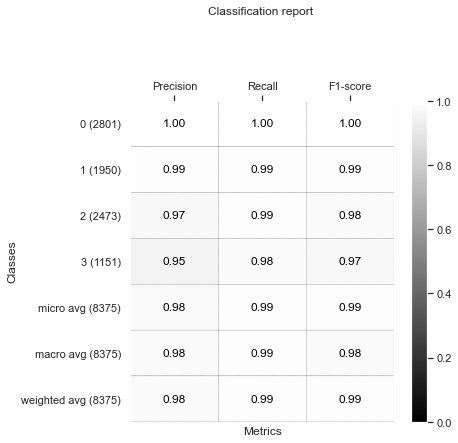

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 15
    figure_height = len(class_names) + 8
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.savefig("InceptionV3MultiLabelCR_v2", bbox_inches='tight', dpi=300)
    plt.show()
    
    
cr = classification_report(Y_true, Y_pred)
plot_classification_report(cr, number_of_classes= 8, title='Classification report ', cmap=plt.cm.gray)

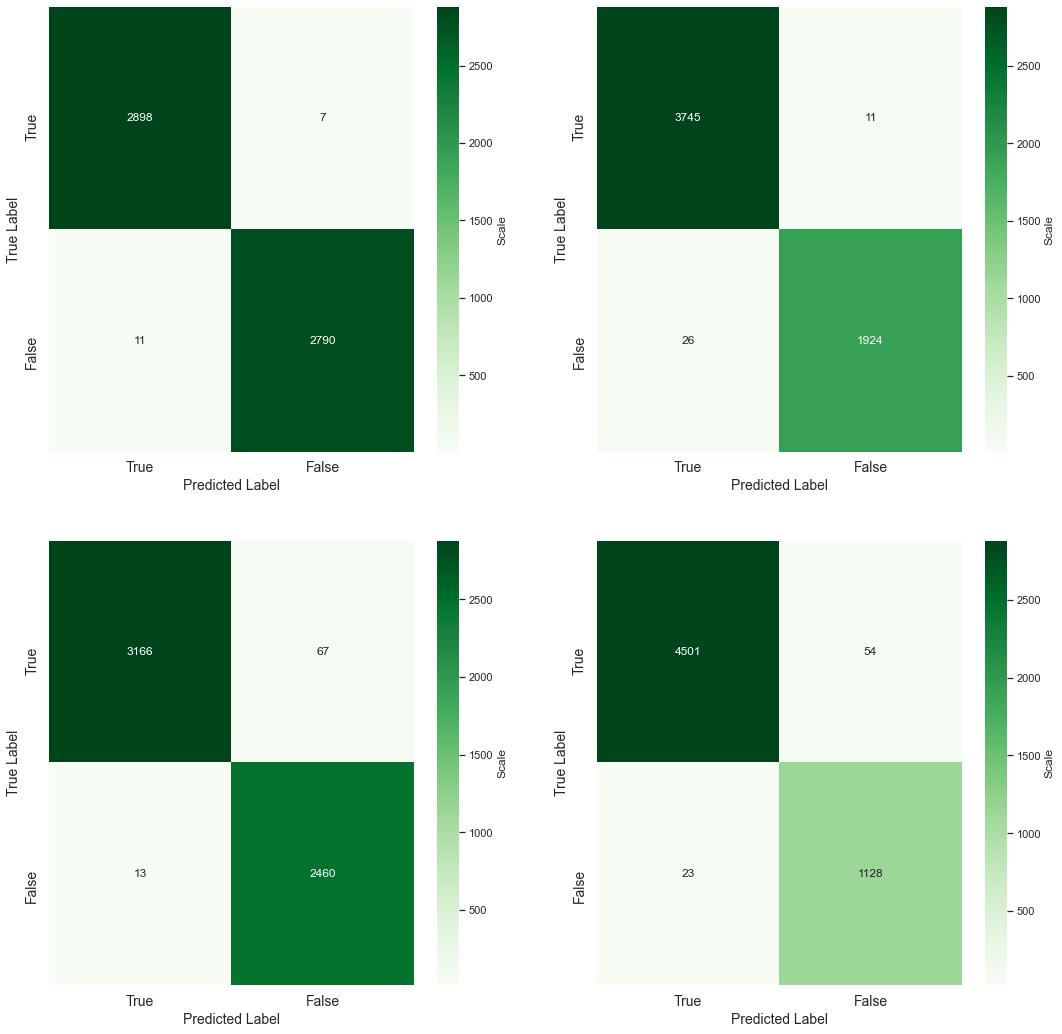

In [92]:
def plot_confusion_matrix(data, labels, title):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    #plt.figure()
 
    ax = seaborn.heatmap(data, annot=True, cmap='Greens', vmax=2880, fmt =".0f", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels, fontsize = 14)
    ax.set_yticklabels(labels, fontsize = 14)
 
    ax.set_xlabel("Predicted Label", fontsize = 14)
    ax.set_ylabel("True Label", fontsize = 14)
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    #plt.close()
    #plt.imshow()
    
 
# define data
plt.figure(figsize=(18,18))
titles=["0_in Ordnung", "1_Doppelwindung", "2_Luecke", "3_Kreuzung"]

for i in range(4):
    plt.subplot(2,2,i+1)
    data = mlcm[i,:,:] 
    title = titles[i]
    # define labels
    labels = ["True", "False"]

    # create confusion matrix
    plot_confusion_matrix(data, labels, title)


plt.imshow
plt.savefig("InceptionV3MultiLabelConfusionMatrix_v1", bbox_inches='tight', dpi=300)

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

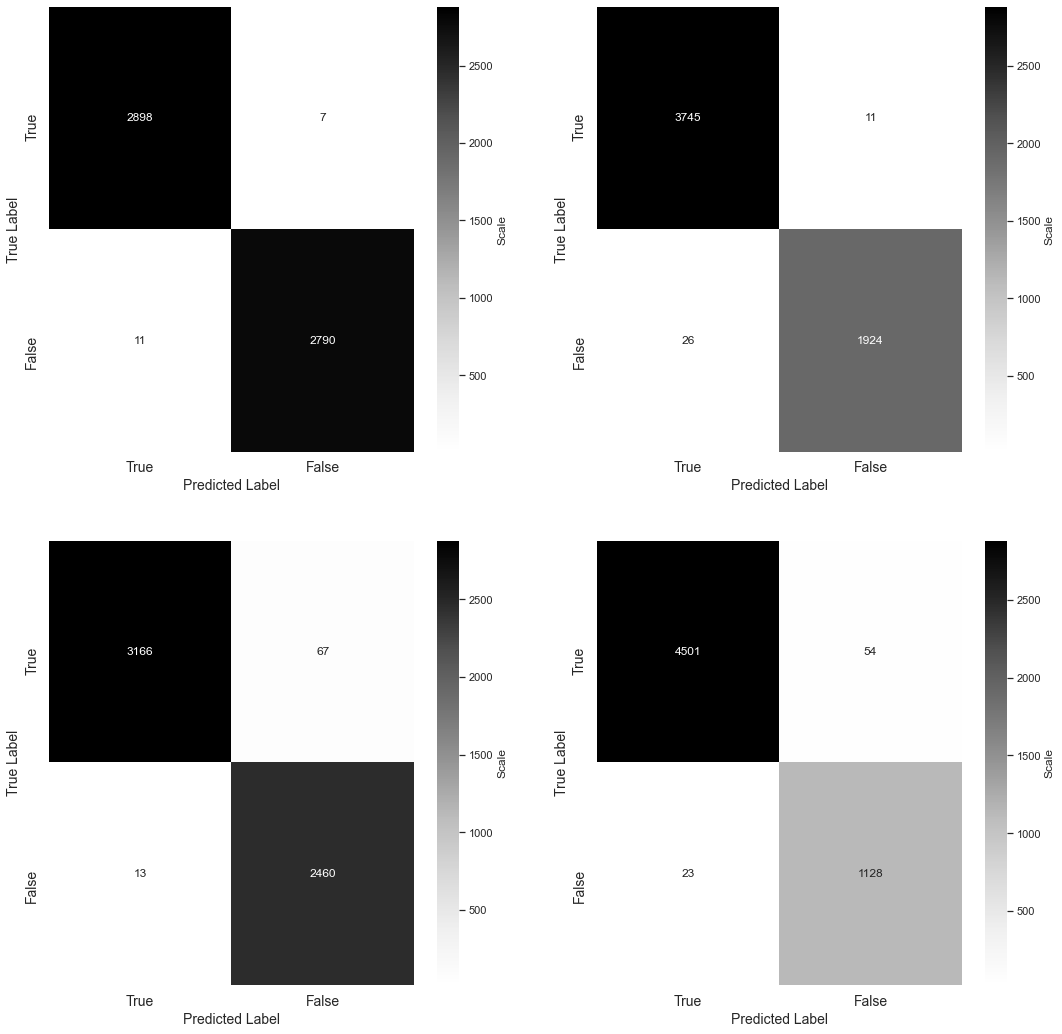

In [94]:
def plot_confusion_matrix(data, labels, title):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    #plt.figure()
 
    ax = seaborn.heatmap(data, annot=True, cmap='Greys', vmax=2880, fmt =".0f", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels, fontsize = 14)
    ax.set_yticklabels(labels, fontsize = 14)
 
    ax.set_xlabel("Predicted Label", fontsize = 14)
    ax.set_ylabel("True Label", fontsize = 14)
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    #plt.close()
    #plt.imshow()
    
 
# define data
plt.figure(figsize=(18,18))
titles=["0_in Ordnung", "1_Doppelwindung", "2_Luecke", "3_Kreuzung"]

for i in range(4):
    plt.subplot(2,2,i+1)
    data = mlcm[i,:,:] 
    title = titles[i]
    # define labels
    labels = ["True", "False"]

    # create confusion matrix
    plot_confusion_matrix(data, labels, title)


plt.imshow
#plt.savefig("InceptionV3MultiLabelConfusionMatrix_v1", bbox_inches='tight', dpi=300)